# Initialise paramters

Will have to manually authenticate ee.

In [40]:
import ee

# Trigger the authentication flow.
#ee.Authenticate()

# Initialize the library.
ee.Initialize()

In [90]:
import geopandas as gp
import pandas as pd
import matplotlib.pyplot as plt
import json
import pickle
import os.path

from shapely.ops import unary_union
from shapely.geometry import Polygon, shape, Point

import numpy as np

from datetime import timedelta, datetime

from typing import Tuple
from itertools import cycle

import torch.nn as nn
import torch

from torch.utils.data import Subset

from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import time
import matplotlib.pyplot as plt

Parameters for automated run. Should be most recent date that HYCOM has data for. Check dataset availability [here](https://developers.google.com/earth-engine/datasets/catalog/HYCOM_sea_water_velocity). Usually it is 2 days behind.

In [41]:
# year, month, date
date = datetime(2022,10,20)
# time frame for the model
timespan = 7
# number of points to sample from the atlantic, and request api data for to predict
sample_n = 10000
# filepath of model to use for inference
model_path = r"model_checkpoints/GRU_epoch_1500_loss_3.401.pt"

# Get inference region points

In [6]:
tes = gp.read_file(r'data\iho\iho.shp')
df = tes.loc[tes.name.isin(['South Atlantic Ocean', 'North Atlantic Ocean'])]
df

,name,id,longitude,latitude,min_x,min_y,max_x,max_y,area,mrgid,geometry
7,South Atlantic Ocean,32,-18.808767,-33.732396,-69.600837,-60.000000,20.009049,0.075106,40501812.0,1914,"POLYGON ((8.97417 -0.93603, 8.97515 -0.93592, ..."
9,North Atlantic Ocean,23,-37.624244,29.480034,-83.014914,-0.002563,6.619967,68.638716,34507128.0,1912,"POLYGON ((-6.26384 62.34582, -6.17706 62.32412..."


<AxesSubplot:>

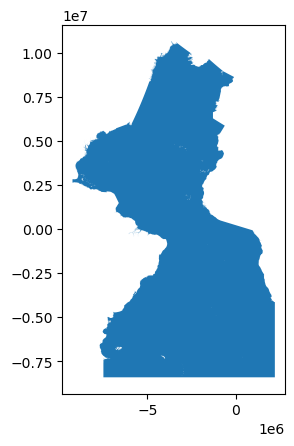

In [7]:
atlantic = df.dissolve().to_crs(epsg=3857)
atlantic.plot()

In [8]:
atlantic.geometry[0].bounds

(-9241177.971966805,
 -8399737.889818331,
 2227397.1613292582,
 10639472.197641218)

There does not exist inbuilt library methods to sample points within a geometry, especially not rectangular points. Using shapely's .contains() method to check if a point is in the atlantic takes a full second because the atlantic shape has a huge number of vertices. The fastest method is to filter the points using a spatial join with the points as the main table. Joining with the atlantic as the main table is pretty slow. We use a right join and then drop all NAs which are points not inside the atlantic region. We repeat this a multitude of times until we get a number of points that satisfies the requested number.

In [36]:
# 10 x 10 km wide squares
length = 10000
wide = 10000

def random_rects_in_polygon(number, polygon):
    regions = []
    regions_gpd = gp.GeoDataFrame()
    min_x, min_y, max_x, max_y = polygon.bounds
    while regions_gpd.shape[0] < number:
        for j in range(5000):
            x, y = np.random.uniform(min_x, max_x), np.random.uniform(min_y, max_y)
            rect = Polygon([(x,y), (x+wide, y), (x+wide, y+length), (x, y+length)])
            regions.append(rect)
        regions_gpd = gp.sjoin(atlantic, gp.GeoDataFrame(regions, geometry=0, crs='epsg:3857'), how='right').dropna()
    return regions_gpd.iloc[:sample_n]

data_points = random_rects_in_polygon(sample_n, atlantic.geometry[0])
data_points

,index_left,name,id,longitude,latitude,min_x,min_y,max_x,max_y,area,mrgid,0
3,0.0,South Atlantic Ocean,32,-18.808767,-33.732396,-69.600837,-60.0,20.009049,0.075106,40501812.0,1914.0,"POLYGON ((-4409769.411 -8057203.776, -4399769...."
5,0.0,South Atlantic Ocean,32,-18.808767,-33.732396,-69.600837,-60.0,20.009049,0.075106,40501812.0,1914.0,"POLYGON ((-4822100.275 5822058.333, -4812100.2..."
6,0.0,South Atlantic Ocean,32,-18.808767,-33.732396,-69.600837,-60.0,20.009049,0.075106,40501812.0,1914.0,"POLYGON ((-7536648.395 4413796.076, -7526648.3..."
7,0.0,South Atlantic Ocean,32,-18.808767,-33.732396,-69.600837,-60.0,20.009049,0.075106,40501812.0,1914.0,"POLYGON ((-1158582.847 -3140553.221, -1148582...."
8,0.0,South Atlantic Ocean,32,-18.808767,-33.732396,-69.600837,-60.0,20.009049,0.075106,40501812.0,1914.0,"POLYGON ((-2999474.096 3657267.009, -2989474.0..."
...,...,...,...,...,...,...,...,...,...,...,...,...
17857,0.0,South Atlantic Ocean,32,-18.808767,-33.732396,-69.600837,-60.0,20.009049,0.075106,40501812.0,1914.0,"POLYGON ((-631690.433 -6417164.416, -621690.43..."
17858,0.0,South Atlantic Ocean,32,-18.808767,-33.732396,-69.600837,-60.0,20.009049,0.075106,40501812.0,1914.0,"POLYGON ((-2976471.824 6327900.408, -2966471.8..."
17859,0.0,South Atlantic Ocean,32,-18.808767,-33.732396,-69.600837,-60.0,20.009049,0.075106,40501812.0,1914.0,"POLYGON ((-6980251.008 -6234865.654, -6970251...."
17862,0.0,South Atlantic Ocean,32,-18.808767,-33.732396,-69.600837,-60.0,20.009049,0.075106,40501812.0,1914.0,"POLYGON ((334860.528 -334353.703, 344860.528 -..."


<AxesSubplot:>

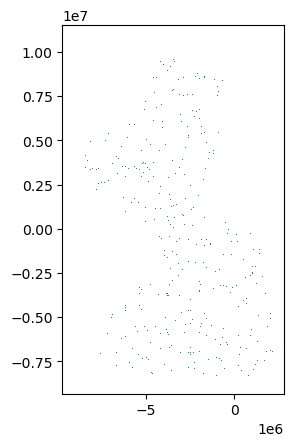

In [37]:
data_points.plot()

# Request data from API

In [38]:
def extract_raster_values_from_df(df, image_collection, band_names, task_name, date, folder="exported_files", lookback_days=3, scale=5000, export=False):
    df['ee_region'] = df.geometry.apply(lambda x: ee.Geometry.Polygon(list((x.exterior.coords)), proj='EPSG:3857'))
    regionCollection = ee.List([])
    emptyCol = ee.FeatureCollection(ee.Feature(None))
    
    # iterate through all entries
    for row in df.itertuples():
        # instantiate the image collection for the selected time series
        collection = ee.ImageCollection(image_collection).filterDate((date - timedelta(days=lookback_days)).strftime('%Y-%m-%d'), date.strftime('%Y-%m-%d')).select(band_names)
        
        # get the raster information based on the buffer region we created
        pixelInfoRegion = collection.getRegion(geometry=getattr(row, 'ee_region'), scale=scale)

        # remove the first element, which is the header ['id', 'longitude', 'latitude', 'time', 'velocity_u_0', 'velocity_v_0']
        pixelInfoRegion = pixelInfoRegion.remove(pixelInfoRegion.get(0))
        # convert the 2d list of information to features. Going to hard code this part as I cba
        def func(x):
            x = ee.List(x)
            feat = ee.Feature(ee.Geometry.Point([x.get(1), x.get(2)], proj='EPSG:4326'), {'time':x.get(3),'velocity_u_0':x.get(4),'velocity_v_0':x.get(5)})
            return feat
        col = ee.FeatureCollection(pixelInfoRegion.map(func))
        # add the region that we created to the overall feature collection
        
        # ensure collection is not empty bands
        regionCollection = regionCollection.add(ee.Algorithms.If(collection.size(), col, emptyCol))
    
    if export:
        return ee.batch.Export.table.toDrive(collection=ee.FeatureCollection(regionCollection).flatten(), description=task_name, fileFormat="csv", folder=folder)
    else:
        return ee.FeatureCollection(regionCollection).flatten()

Kernel keeps crashing when we task.start() for too many points.

In [42]:
size = 500
for i in range(0, sample_n, size):
    task_name = f"atlantic_water_velocities_{i}"
    task = extract_raster_values_from_df(data_points.iloc[i:i+size].copy(), 'HYCOM/sea_water_velocity', ['velocity_u_0', 'velocity_v_0'], task_name, date, folder=f"exported_files/{date.strftime('%d.%m.%Y')}", lookback_days=timespan, export=True)
    task.start()

Assert that exported data is in the directory for use. If not, manually copy them over :)

In [43]:
assert os.path.isfile(f"data/data_files/{date.strftime('%d.%m.%Y')}/atlantic_water_velocities_0.csv") 

In [44]:
size = 500
df_list = []
for i in range(0, sample_n, size):
    sub_df = pd.read_csv(f"data/data_files/{date.strftime('%d.%m.%Y')}/atlantic_water_velocities_{i}.csv")
    
    water_idx = sub_df['system:index'].str.split('_', expand=True)
    water_idx = water_idx.rename(columns={0:'cluster', 1:'index'})
    water_idx['cluster'] = water_idx['cluster'].astype(int) + i
    
    sub_df = sub_df.join(water_idx).drop(columns=['system:index'])
    
    df_list.append(sub_df)
    
water_df = pd.concat(df_list, axis=0)
water_df

,time,velocity_u_0,velocity_v_0,.geo,cluster,index
0,1.665619e+12,225.0,-179.0,"{""type"":""Point"",""coordinates"":[-39.59324614756...",0,0
1,1.665630e+12,187.0,-213.0,"{""type"":""Point"",""coordinates"":[-39.59324614756...",0,1
2,1.665641e+12,225.0,-226.0,"{""type"":""Point"",""coordinates"":[-39.59324614756...",0,2
3,1.665652e+12,239.0,-168.0,"{""type"":""Point"",""coordinates"":[-39.59324614756...",0,3
4,1.665662e+12,191.0,-119.0,"{""type"":""Point"",""coordinates"":[-39.59324614756...",0,4
...,...,...,...,...,...,...
86011,1.666170e+12,-203.0,-48.0,"{""type"":""Point"",""coordinates"":[-32.27197658199...",9999,219
86012,1.666181e+12,-310.0,-89.0,"{""type"":""Point"",""coordinates"":[-32.27197658199...",9999,220
86013,1.666192e+12,-336.0,-148.0,"{""type"":""Point"",""coordinates"":[-32.27197658199...",9999,221
86014,1.666202e+12,-338.0,-194.0,"{""type"":""Point"",""coordinates"":[-32.27197658199...",9999,222


In [45]:
water_df.isna().any(axis=1).sum()

13552

Some clusters will be NaN values, remove those.

In [46]:
water_df['.geo'] = water_df['.geo'].apply(json.loads).apply(shape)
water_df = water_df.dropna().set_index(['cluster'])
remap = dict(zip(water_df.index.unique(), list(range(len(water_df.index.unique())))))
water_df = water_df.rename(index=remap).set_index(['index'], append=True)
water_df = gp.GeoDataFrame(water_df, geometry='.geo')
water_df

time  velocity_u_0  velocity_v_0  \
cluster index                                             
0       0      1.665619e+12         225.0        -179.0   
        1      1.665630e+12         187.0        -213.0   
        2      1.665641e+12         225.0        -226.0   
        3      1.665652e+12         239.0        -168.0   
        4      1.665662e+12         191.0        -119.0   
...                     ...           ...           ...   
9891    219    1.666170e+12        -203.0         -48.0   
        220    1.666181e+12        -310.0         -89.0   
        221    1.666192e+12        -336.0        -148.0   
        222    1.666202e+12        -338.0        -194.0   
        223    1.666213e+12        -269.0        -176.0   

                                      .geo  
cluster index                               
0       0      POINT (-39.59325 -58.41295)  
        1      POINT (-39.59325 -58.41295)  
        2      POINT (-39.59325 -58.41295)  
        3      POINT (-39.59325 -58.41295)  
        4      POINT (-39.59325 -58.41295)  
...                                    ...  
9891    219    POINT (-32.27198 -15.20399)  
        220    POINT (-32.27198 -15.20399)  
        221    POINT (-32.27198 -15.20399)  
        222    POINT (-32.27198 -15.20399)  
        223    POINT (-32.27198 -15.20399)  

[1718864 rows x 4 columns]

In [47]:
images = []
largestx, largesty = -1, -1
counter = 0
for key, cluster_df in water_df.groupby(level=0):
    cluster_df = cluster_df.droplevel(0)

    cluster_df.time = pd.to_datetime(cluster_df.time, unit='ms').dt.strftime('%Y-%m-%d')
    cluster_df.time = pd.Categorical(cluster_df.time)
    
    cluster_df.time = cluster_df.time.cat.rename_categories(list(range(len(cluster_df.time.cat.categories))))

    cluster_df['x'] = pd.Categorical(cluster_df.geometry.x)
    cluster_df['y'] = pd.Categorical(cluster_df.geometry.y)
    cluster_df.x = cluster_df.x.cat.rename_categories(list(range(len(cluster_df.x.cat.categories))))
    cluster_df.y = cluster_df.y.cat.rename_categories(list(range(len(cluster_df.y.cat.categories))))

    time, maxx, maxy = cluster_df.time.cat.categories[-1] + 1, cluster_df.x.cat.categories[-1] + 1, cluster_df.y.cat.categories[-1] + 1
    
    # i don't want to deal with this shit
    if (time != timespan): 
        counter += 1
        continue

    cluster_df = cluster_df.pivot_table(values=['velocity_u_0', 'velocity_v_0'], index=['time', 'y', 'x'], aggfunc=np.sum)
    img = cluster_df.to_numpy().reshape([time, maxy, maxx, -1])
    largestx, largesty = max(maxx, largestx), max(maxy, largesty)
    
    # [(x, y), img]
    pos = water_df.loc[key].iloc[0].loc['.geo']
    images.append([(pos.x, pos.y), img])
    
len(images), largestx, largesty

(9892, 4, 4)

Just in case we need to rerun any inference, the data doesn't have to be reprocessed.

In [56]:
with open('data/latest_atlantic_data.pickle', 'wb') as handle:
    pickle.dump(images, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Model Inference

Define the GRU model

In [61]:
def conv_output_shape(h_w, kernel_size, stride=1, pad=0, dilation=1):
    """
    Utility function for computing output of convolutions
    takes a tuple of (d,h,w) and returns a tuple of (d,h,w)
    """

    if type(h_w) is not tuple:
        h_w = (h_w, h_w, h_w)

    if type(kernel_size) is not tuple:
        kernel_size = (kernel_size, kernel_size)

    if type(stride) is not tuple:
        stride = (stride, stride)

    if type(pad) is not tuple:
        pad = (pad, pad)

    h = (h_w[0] + (2 * pad[0]) - (dilation * (kernel_size[0] - 1)) - 1) // stride[0] + 1
    w = (h_w[1] + (2 * pad[1]) - (dilation * (kernel_size[1] - 1)) - 1) // stride[1] + 1

    return h, w

class GRUNet(nn.Module):
    """
    The input is expected to be a 5d tensor of dims [batch_size, time_steps, height, width, n_features]
    representing a height*width region for a certain time_steps period. The region would contain n_features of
    water_velocity, etc. to predict the final output. The final output will be 1 number representing the amount of
    microplastics pieces/m^3.
    """

    def __init__(self, input_dims: Tuple[int], hidden_size: int, output_dim=1, n_layers=1, drop_prob=0):
        super(GRUNet, self).__init__()

        self.batch_size, self.time_steps, self.height, self.width, self.n_features = input_dims

        # hidden size refers to the dimensions of the GRUs hidden state
        self.hidden_size = hidden_size
        # should be 1, as we are predicting only total microplastic concentration in that height*width region
        self.output_dim = output_dim
        # number of stacked GRUs (default 1)
        self.n_layers = n_layers

        # 1*3*3 kernel makes it independent of the time_steps dimension, but n_features being the channel makes sure the
        # convolutions depend on the value of the features of the surrounding pixels
        self.feature_kernel = (1, 3, 3)

        # series of convolutions to reduce dimensionality of height*width*n_features to height*width*1
        # Quite sure ts0 = time_steps as number of time steps should not be changed throughout the convolutions
        # [batch_size, n_features, time_steps, height, width] -> [batch_size, n_features, ts0, h0, w0]
        self.conv0 = nn.Conv3d(self.n_features, self.n_features, self.feature_kernel)
        h0, w0 = conv_output_shape((self.height, self.width), (3, 3))
        # TODO: Add more conv layers
        self.conv1 = nn.Conv3d(self.n_features, self.n_features, self.feature_kernel)
        h1, w1 = conv_output_shape((h0, w0), (3, 3))
        # normalize after convolutions
        self.norm = nn.BatchNorm3d(self.n_features)

        # this final conv layer will learn to compress n_features into 1 number, essentially a 1*1*1*n_features kernel
        # -> [batch_size, 1, ts0, h0, w0]
        self.feature_conv = nn.Conv3d(self.n_features, 1, (1,1,1))
        # squeeze out the 1 dim.
        # -> [batch_size, ts0, h0*w0] flattened final feature map of last 2 dims
        self.flatten = nn.Flatten(-2,-1)

        # input size of GRU will be the flattened feature map size = h0 * w0
        self.gru = nn.GRU(h1*w1, self.hidden_size, self.n_layers, batch_first=True, dropout=drop_prob)
        self.fc0 = nn.Linear(self.hidden_size, self.hidden_size//2)
        self.fc1 = nn.Linear(self.hidden_size//2, self.output_dim)

        self.relu = nn.ReLU()

    def forward(self, x, h):
        # permute as conv3d accepts inputs of [batch_size, channels/n_features, D/time_steps, H, W]
        x = torch.permute(x, (0, 4, 1, 2, 3))
        x = self.conv0(x)
        x = self.conv1(x)
        x = self.norm(x)
        x = self.feature_conv(x)
        x = torch.permute(x, (0, 2, 3, 4, 1))
        # remove the 1 dimensional n_features channel. new shape [batch_size, time_steps, height, width]
        x = torch.squeeze(x)
        # flatten the height x width channel into a final feature map. -> [batch_size, time_steps, height * width]
        x = self.flatten(x)

        out, h = self.gru(x, h)
        out = self.fc0(self.relu(out[:, -1]))
        out = self.fc1(self.relu(out))
        out = torch.squeeze(out)
        
        # this is not part of the original model, but is added for inference
        # as we do not actually want negative values as output
        out = self.relu(out)

        return out, h

    def init_hidden(self, batch_size):
        weight = next(self.gru.parameters()).data
        hidden = weight.new(self.n_layers, batch_size, self.hidden_size).zero_().to(device)
        return hidden

Define our image dataset

In [62]:
class CustomImageDataset(Dataset):
    def __init__(self, max_shape=(11,11), data_file=r"data/latest_atlantic_data.pickle"):
        with open(data_file, 'rb') as handle:
            # train_files holds a list of [label, time_series] pairs
            # where each label themselves are a list of densities for each time frame.
            train_data = pickle.load(handle)

        # the different time series data are all of different shapes. We have to pad them on the fly.
        self.coords, self.images = zip(*train_data)
        self.height, self.width = max_shape

    def __len__(self):
        return len(self.coords)

    def __getitem__(self, idx):
        coords = self.coords[idx]
        image = self.images[idx]
        
        # calculate margins for paddings
        top = int(np.floor((self.height - image.shape[1])/2.0))
        bottom = int(np.ceil((self.height - image.shape[1])/2.0))
        left = int(np.floor((self.width - image.shape[2])/2.0))
        right = int(np.ceil((self.width - image.shape[2])/2.0))
        
        # pad the image -> [don't pad time, pad height, pad width, don't pad channels]
        image = np.pad(image, [(0, 0), (top, bottom), (left, right), (0, 0)])
        return coords, image

Instantiate the GRU model

In [63]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

# copied the same parameters as the model was trained with.
hidden_dim = 128
batch_size = 128
time_steps = 7
height = 11
width = 11
n_features = 2
output_dim = 1
n_layers = 1
drop_prob = 0
input_dim = (batch_size, time_steps, height, width, n_features)

In [64]:
# load model in eval mode
model = GRUNet(input_dim, hidden_dim, output_dim, n_layers, drop_prob)
model.load_state_dict(torch.load(model_path))
model = model.to(device)

Run model on the data. We might end up with less data because drop_last=True is set to prevent model from breaking when the total dataset size is not divisible by batch_size

In [65]:
dataset = CustomImageDataset(max_shape=(11, 11), data_file='data/latest_atlantic_data.pickle')
loader = DataLoader(dataset, batch_size=128, shuffle=False, drop_last=True)

# list of batch_size tensors
results = list()

with torch.inference_mode():
    for coords, img in loader:
        h = model.init_hidden(batch_size)
        output, h = model.forward(img.to(device).float(), h)
        results.append(torch.stack(coords + [output.cpu()], dim=1))
        
results = torch.cat(results)
results

tensor([[-39.5932, -58.4130,   0.0894],
        [-43.2763,  46.2857,   0.1925],
        [-67.6656,  36.8534,   0.0000],
        ...,
        [-18.4828,  62.3655,   0.0000],
        [-10.0387, -58.1435,   0.3133],
        [-45.4323,  11.1167,   7.1942]], dtype=torch.float64)

In [66]:
results.shape

torch.Size([9856, 3])

Memory consumption since start of the program. The relevant part would be active_bytes.all as it provides the current and peak memory allocations. 

In [67]:
torch.cuda.memory_stats(device)

OrderedDict([('active.all.allocated', 4329),
             ('active.all.current', 18),
             ('active.all.freed', 4311),
             ('active.all.peak', 25),
             ('active.large_pool.allocated', 570),
             ('active.large_pool.current', 0),
             ('active.large_pool.freed', 570),
             ('active.large_pool.peak', 2),
             ('active.small_pool.allocated', 3759),
             ('active.small_pool.current', 18),
             ('active.small_pool.freed', 3741),
             ('active.small_pool.peak', 24),
             ('active_bytes.all.allocated', 4532470272),
             ('active_bytes.all.current', 380928),
             ('active_bytes.all.freed', 4532089344),
             ('active_bytes.all.peak', 21008384),
             ('active_bytes.large_pool.allocated', 3917660160),
             ('active_bytes.large_pool.current', 0),
             ('active_bytes.large_pool.freed', 3917660160),
             ('active_bytes.large_pool.peak', 18884608),
        

As convention is latitude (y) longitude (x), we will output the results of the model inference in a json format. However, some geodesic formats prefer longitude/latitude because it has a direct mapping with the x/y convention.

In [89]:
f = open("demofile2.txt", "a")
f.write(json.dumps([{'lat':lat, 'lng':lng, 'conc':conc} for lat,lng,conc in results.tolist()]))
f.close()



'[{"lat": -39.5932461475679, "lng": -58.41295134987189, "conc": 0.08942313492298126}, {"lat": -43.276338812457944, "lng": 46.285695014258344, "conc": 0.19248028099536896}, {"lat": -67.66559877630296, "lng": 36.85338453100337, "conc": 0.0}, {"lat": -10.39799941368346, "lng": -27.10666369830656, "conc": 2.7318906784057617}, {"lat": -26.92700064148266, "lng": 31.193998241050384, "conc": 0.19545359909534454}, {"lat": -44.578895974431255, "lng": -53.92137492927428, "conc": 0.0}, {"lat": -6.62507522038147, "lng": -6.31066487093964, "conc": 0.0}, {"lat": 14.305670899603378, "lng": -57.60446759416431, "conc": 0.2579743266105652}, {"lat": -31.55332435469819, "lng": 1.9987515071659352, "conc": 4.755989074707031}, {"lat": -44.75855903125516, "lng": 52.61881776730097, "conc": 2.8581960201263428}, {"lat": -18.16842662131732, "lng": -16.596374874108157, "conc": 0.0}, {"lat": -37.796615579328865, "lng": 20.638793652646008, "conc": 0.0}, {"lat": -71.30377567698702, "lng": 30.7897563631966, "conc": 0.4